In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import math
from scipy.special import factorial
from scipy.stats import rv_continuous

from tqdm.autonotebook import trange

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_24595/1887460004.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [3]:
sns.set_theme(
    context='paper', 
    palette='colorblind',
    style='whitegrid',
    rc={'text.usetex':True, 'mathtext.fontset':'cm'},
)

# Spike Trains in a Finite Window

In [48]:
def sample_spike_trains(duration, firing_rate, num_channels=1):
    """
    Returns a single- or multi-channel periodic spike train by forward sampling.

    Args:
        duration (float): The duration of the spike train in [tau_min].
        firing_rate (float): The firing rate of the spike train in [1/\tau_min].
        num_channels (int, optional): The number of channels / neurons. Defaults to 1.
        
    Raises:
        ValueError: If the duration is negative.
        ValueError: If the firing rate is negative.

    Returns:
        (List[np.ndarray]): a single- or multi-channel spike train in a window [0, duration).
    """            
    if duration < 0:
        raise ValueError(f"The period should be non-negative.")
        
    if firing_rate < 0:
        raise ValueError(f"The firing rate should be non-negative.")
    
    if duration <= 1 or firing_rate == 0:
        return [np.array([])]*num_channels
    
    spike_trains = []
    for _ in trange(num_channels, desc="Sampling"): 
        # Uniformly chose the first spike in a large interval far before the begining of the window of interest
        fts = np.random.uniform(0, duration, 1)-10*duration # connect to firing_rate?

        # Sample firing times until the end of the window is reached
        while fts[-1] < duration:
            fts = np.append(fts, fts[-1] + 1 + np.random.exponential(1/firing_rate))
        
        spike_trains.append(fts[(fts >= 0)*(fts < duration)])

    return spike_trains

def get_num_spikes_distribution(period, firing_rate):
    raise NotImplementedError
    
def expected_number_of_firings(duration, firing_rate):      
    raise NotImplementedError

In [50]:
spike_trains = sample_spike_trains(1000, 0.1, 10000)

Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# TODO: same analysis as for periodic spike trains (easier)

# Periodic Spike Trains

In [7]:
def sample_spike_trains(period, firing_rate, num_channels=1):    
    if period < 0:
        raise ValueError(f"The period should be non-negative.")
        
    if firing_rate < 0:
        raise ValueError(f"The firing rate should be non-negative.")
    
    if period <= 1 or firing_rate == 0:
        return [np.array([])]*num_channels
    
    ns = np.arange(1, period, dtype=int)
    
    #pns = np.nan_to_num(np.power(firing_rate * (period - ns)*np.exp(firing_rate), ns) / ((period-ns)*factorial(ns-1)))
    #pns /= np.sum(pns) # normalize
    
    # for numerical stability, first compute log p(n | n > 0) (unnormalized)
    lnpns = (ns-1) * (np.log(firing_rate) + np.log(period - ns)) 
    lnpns += np.log(firing_rate) 
    lnpns -= firing_rate * (period - ns)
    lnpns[1:] -= np.cumsum(np.log(ns[:-1]))
    
    # then, compute and normalize p(n | n > 0)
    pns = np.exp(lnpns)
    pns /= np.sum(pns)

    # init the list of arrays of firing times
    spike_trains = []

    for _ in trange(num_channels, desc="Sampling"):        
        # empty spike train?
        if np.random.binomial(1, np.exp(-firing_rate*(period - 1))):
            spike_trains.append(np.array([]))
            continue

        # number of spikes (conditionned on non empty)? (WARNING: possibility of overflow error)
        n = np.random.choice(ns, p=pns)

        # firing times? (conditionned on number of spikes and spikes at location 0 and period)
        tfs = np.full(n, period, dtype=float)
        for m in range(n - 1, 0, -1):
            # sample firing times by inverse sampling with the quantile function 
            u = np.random.uniform(0, 1)
            tfs[m-1] = np.power(u, 1/m) * (tfs[m] - (m+1)) + m
            
            # ts = np.arange(m+res, tfs[m]-1, res)
            # pts = np.nan_to_num(np.power((ts-m)/(tfs[m]-m-1), m-1) * m / (ts-m))
            # pts = pts / pts.sum()

            #psm = norm(fmus[m] * self.survival_dist.pdf(s[m + 1] - z))
            #tfs[m-1] = np.random.choice(ts, p=pts)

        # Ramdomly shift the firing times cyclically
        spike_trains.append(np.sort((tfs + np.random.uniform(0, period)) % period))

    return spike_trains

#def forward_sampling(period, firing_rate, num_channels=1, res=1e-3):       
#    if period < 0:
#        raise ValueError(f"The period should be non-negative.")
#        
#    if firing_rate < 0:
#        raise ValueError(f"The firing rate should be non-negative.")
#    
#    if period <= 1 or firing_rate == 0:
#        return [np.array([])]*num_channels
#    
#    ns = np.arange(1, period, dtype=int)
#    
#    #pns = np.nan_to_num(np.power(firing_rate * (period - ns)*np.exp(firing_rate), ns) / ((period-ns)*factorial(ns-1)))
#    #pns /= np.sum(pns) # normalize
#    
#    # for numerical stability, first compute log p(n | n > 0) (unnormalized)
#    lnpns = (ns-1) * (np.log(firing_rate) + np.log(period - ns)) 
#    lnpns += np.log(firing_rate) 
#    lnpns -= firing_rate * (period - ns)
#    lnpns[1:] -= np.cumsum(np.log(ns[:-1]))
#    
#    # then, compute and normalize p(n | n > 0)
#    pns = np.exp(lnpns)
#    pns /= np.sum(pns)
#
#    # init the list of arrays of firing times
#    firing_times = []
#
#    for _ in trange(num_channels, desc="Sampling"):        
#        # empty spike train?
#        if np.random.binomial(1, np.exp(-firing_rate*(period - 1))):
#            firing_times.append(np.array([]))
#            continue
#
#        # number of spikes (given n > 0)? (WARNING: possibility of overflow error)
#        n = np.random.choice(ns, p=pns)
#
#        # firing times? (conditionned on number of spikes and spikes at location 0 and period)
#        tfs = np.zeros(n, dtype=float)
#        for m in range(1, n):
#            ts = np.arange(tfs[m-1]+1+res, period - (n - m) - res, res)
#            pts = np.nan_to_num((n-m)*np.power((period - (n-m) - ts)/(period - (n - m + 1) - tfs[m-1]), n-m-1)/(period - (n - m + 1) - tfs[m-1]))
#            pts = pts / pts.sum()
#            tfs[m] = np.random.choice(ts, p=pts)
#            
#        # Ramdomly shift the firing times cyclically
#        firing_times.append(np.sort((tfs + np.random.uniform(0, period)) % period))
#
#    return firing_times

In [29]:
spike_trains = sample_spike_trains(100, 0.2, 1)

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
spike_trains

[array([ 2.00728191,  6.90697463, 13.32897179, 26.00502297, 27.7990937 ,
        31.98324991, 36.52483151, 45.75356117, 48.54192421, 66.67953325,
        72.63700729, 78.67199486, 83.69589407, 93.50643195])]

In [46]:
spike_trains = sample_spike_trains(100, 0.2, 10000)

Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

In [47]:
np.mean([len(fts) for fts in spike_trains])

17.3061

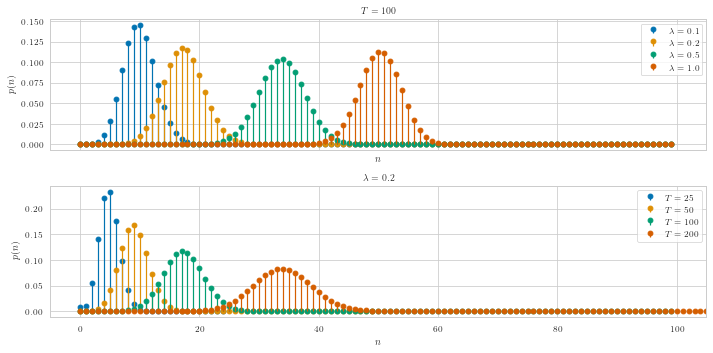

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)

def get_num_spikes_distribution(period, firing_rate):
    ns = np.arange(period, dtype=int)
    pns = np.full_like(ns, np.exp(-firing_rate*(period - 1)), dtype=float)
        
    # for numerical stability, first compute log probabilities
    lnpns = (ns[:-1]) * (np.log(firing_rate) + np.log(period - ns[1:])) 
    lnpns += np.log(firing_rate) 
    lnpns -= firing_rate * (period - ns[1:])
    lnpns[1:] -= np.cumsum(np.log(ns[1:-1]))
    
    pns[1:] = np.exp(lnpns)
    pns[1:] *= (1 - np.exp(-firing_rate*(period - 1))) / np.sum(pns[1:])
    
    #pns[1:] = np.nan_to_num(np.power(firing_rate * (period - ns[1:])*np.exp(firing_rate), ns[1:]) / ((period-ns[1:])*factorial(ns[1:]-1)))
    #pns[1:] /= np.sum(pns[1:])
    #pns[1:] /= 1 - np.exp(-firing_rate*(period - 1))
    return ns, pns

for i, firing_rate in enumerate([0.1, 0.2, 0.5, 1.0]):
    ns, pns = get_num_spikes_distribution(100, firing_rate)
    axes[0].stem(ns, pns, basefmt=" ", markerfmt=f"C{i}o", linefmt=f"C{i}", label=f"$\lambda = {firing_rate:.1f}$")
    
axes[0].set_xlabel("$n$")
axes[0].set_ylabel("$p(n)$")
axes[0].set_title("$T = 100$")
axes[0].legend()

for i, period in enumerate([25, 50, 100, 200]):
    ns, pns = get_num_spikes_distribution(period, 0.2)
    axes[1].stem(ns, pns, basefmt=" ", markerfmt=f"C{i}o", linefmt=f"C{i}", label=f"$T = {period}$")
    
axes[1].set_xlim(-5, 105)
axes[1].set_xlabel("$n$")
axes[1].set_ylabel("$p(n)$")
axes[1].set_title("$\lambda = 0.2$")
axes[1].legend()

fig.tight_layout()

plt.show()

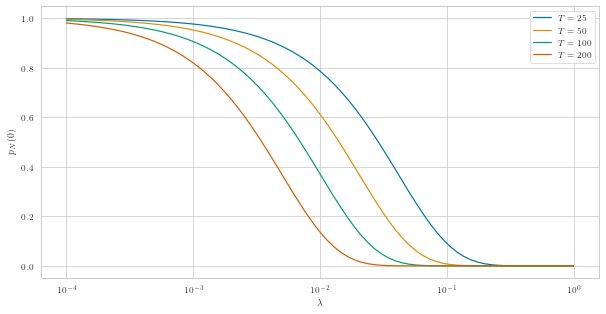

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

firing_rates = np.logspace(-4, 0, 75)
for i, period in enumerate([25, 50, 100, 200]):
    ax.semilogx(firing_rates, np.exp(-firing_rates*(period-1)), color=f"C{i}", label=f"$T = {period}$")

ax.set_xlabel("$\lambda$")
ax.set_ylabel("$p_N(0)$")
ax.legend()

plt.show()

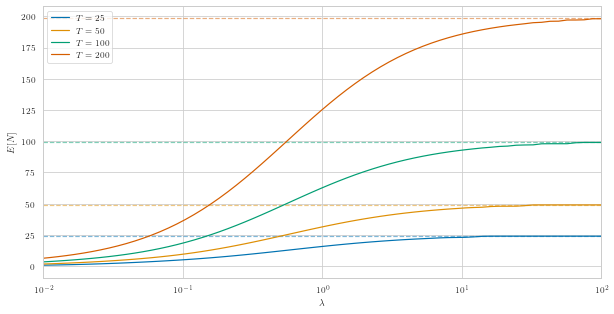

In [14]:
def expected_number_of_firings(period:float, firing_rate:float) -> float:    
    ns = np.arange(1, period, dtype=int)
    
    # for numerical stability, first compute log probabilities
    lnpns = (ns-1) * (np.log(firing_rate) + np.log(period - ns)) 
    lnpns += np.log(firing_rate) 
    lnpns -= firing_rate * (period - ns)
    lnpns[1:] -= np.cumsum(np.log(ns[:-1]))
    
    pns = np.exp(lnpns)
    #pns = np.nan_to_num(np.power(firing_rate * (period - ns)*np.exp(firing_rate), ns) / ((period-ns)*factorial(ns-1)))
    pns *= (1 - np.exp(-firing_rate*(period - 1))) / np.sum(pns)
    
    return np.inner(ns, pns)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i, period in enumerate([25, 50, 100, 200]):
    n_exp = []
    for firing_rate in np.logspace(-2, 2, 75):
        n_exp.append(expected_number_of_firings(period, firing_rate))
    ax.semilogx(np.logspace(-2.5, 2, 75), n_exp, color=f"C{i}", label=f"$T = {period}$")
    ax.axhline(period-1, color=f"C{i}", linestyle="dashed", alpha=0.5)

ax.set_xlim(1e-2, 1e2)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$E[N]$")
ax.legend()

plt.show()

In [15]:
expected_number_of_firings(100, 0.2)

17.36111106740453

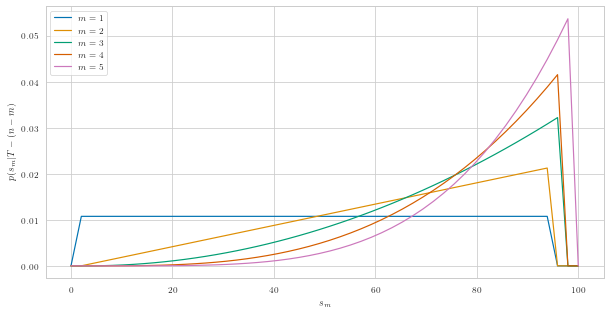

In [40]:
def cond_prob(m, ft, next_ft):
    return (ft > m) * (ft < next_ft - 1) * m * np.power((ft - m)/(next_ft - (m+1)), m-1) / (next_ft - (m+1))
    
    #pfs = np.nan_to_num(m*np.power((t - m)/(period - (n - m + 1)), m-1)/(period - (n - m + 1)))
    ##ptms = ptms / ptms.sum() * (period - (m+1))
    #return ptms
    
fig, ax = plt.subplots(1, 1, figsize=(10,5))

period, firing_rate = 100, 0.2
n = 6
res = 0.1

for m in range(1, n):
    ft = np.linspace(0, period)
    ax.plot(ft, cond_prob(m, ft, period - (n - m)), color=f"C{m-1}", label=f"$m = {m}$")

ax.set_xlabel("$s_m$")
ax.set_ylabel("$p(s_m | T - (n - m)$")
ax.legend()

plt.show()

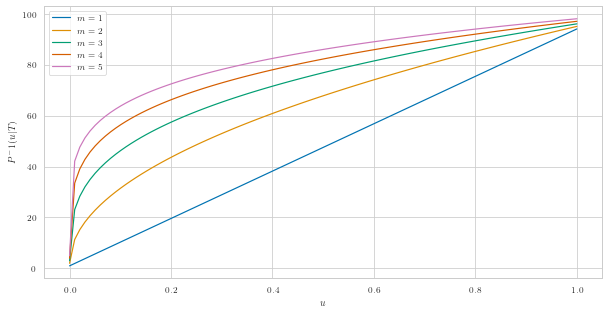

In [43]:
def quantile(m, u, next_ft):
    return (next_ft - (m+1)) * np.power(u, 1/m) + m
    
fig, ax = plt.subplots(1, 1, figsize=(10,5))

period, firing_rate = 100, 0.2
n = 6
res = 0.1

for m in range(1, n):
    u = np.linspace(0, 1, 100)
    ax.plot(u, quantile(m, u, period - (n - m)), color=f"C{m-1}", label=f"$m = {m}$")

ax.set_xlabel("$u$")
ax.set_ylabel("$P^-1(u | T)$")
ax.legend()

plt.show()

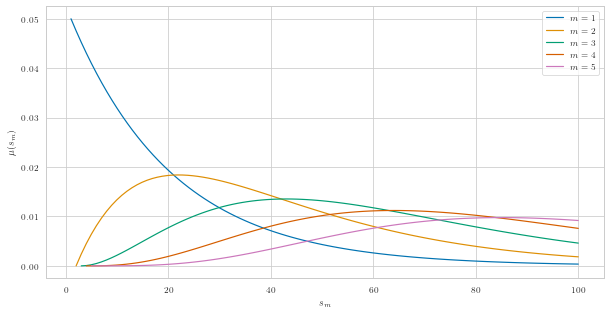

In [17]:
def forward_msg(firing_rate, m, tms, t0=0.0):
    lnmfms = (m-1)*np.log(tms - t0 - m) - firing_rate*(tms - t0 - m) + m * np.log(firing_rate) - np.sum(np.log(np.arange(1, m)))
    mfms = np.exp(lnmfms)
    return mfms

fig, ax = plt.subplots(1, 1, figsize=(10,5))

period, firing_rate = 100, 0.05
n = 6

for m in range(1, n):
    tms = np.linspace(m + 1e-6, period, 100)
    ax.plot(tms, get_forward_msg(firing_rate, m, tms), color=f"C{m-1}", label=f"$m = {m}$")

ax.set_xlabel("$s_m$")
ax.set_ylabel("$\mu(s_m)$")
ax.legend()

plt.show()